In [1]:
from IPython.display import Image

## basics

- 出于节省显存的需要；
    - 句子（sequence）越长，所需的显存越大；
- KV cache or Key-Value cache

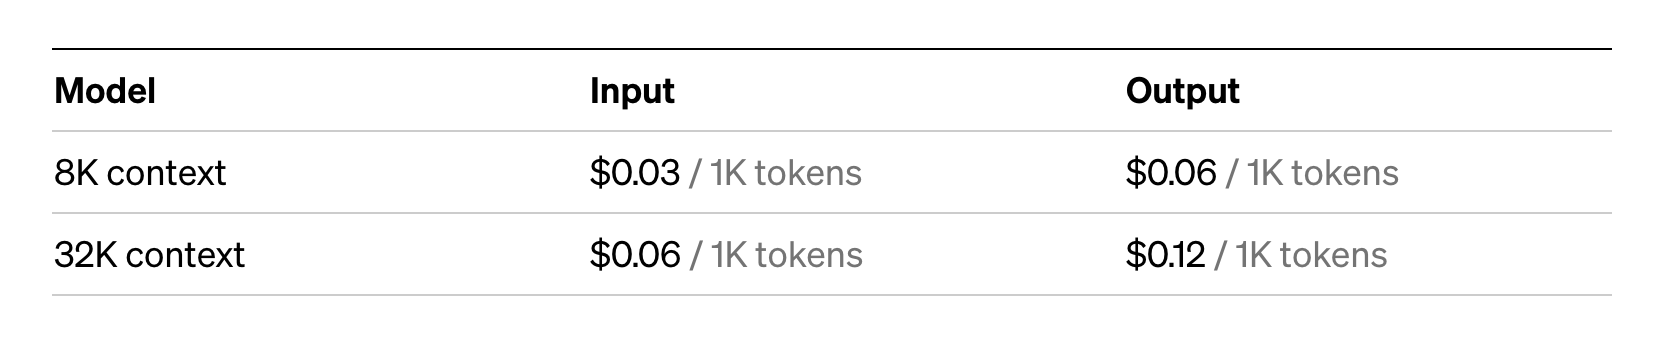

In [4]:
Image('../imgs/gpt4-price.png', width=600)

- self attention
$$
\text{Attention}(Q, K, V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

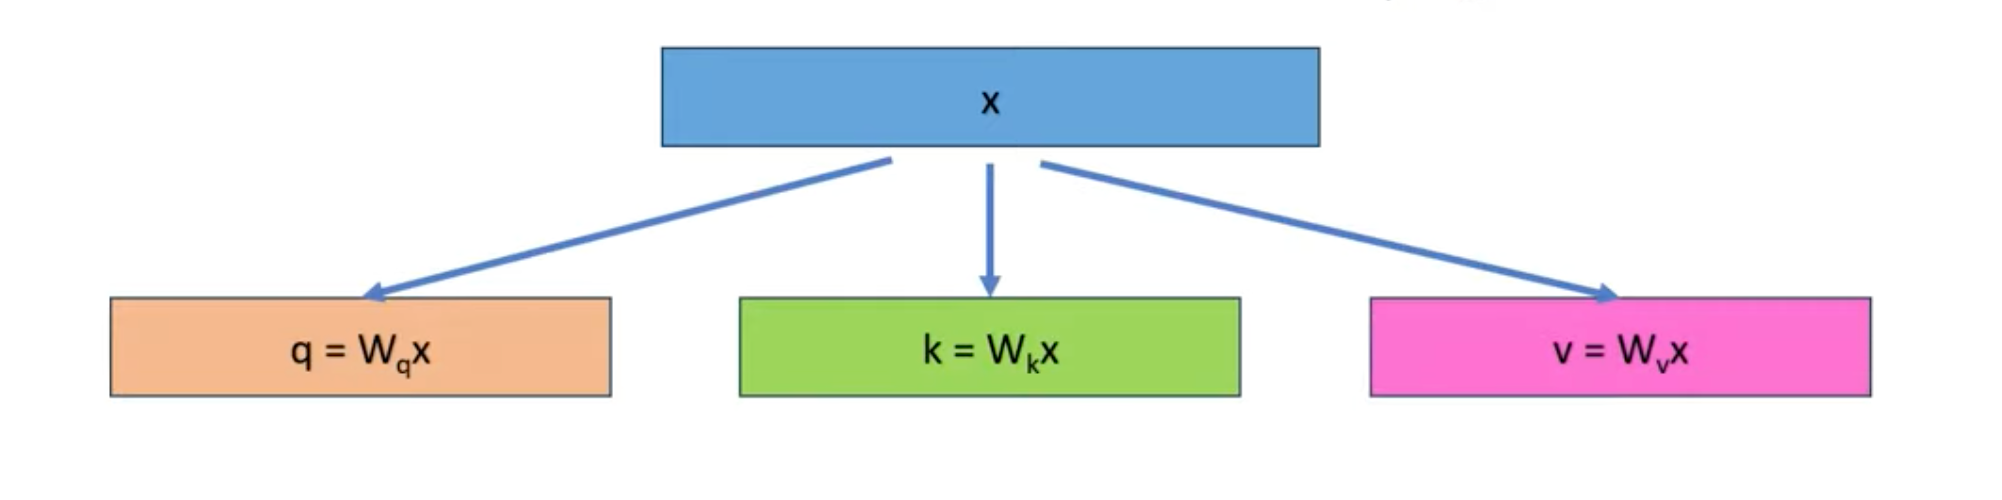

In [6]:
Image('../imgs/qkv.png', width=600)

- x: token embedding
- $W_{q,k,v}$: learned from data

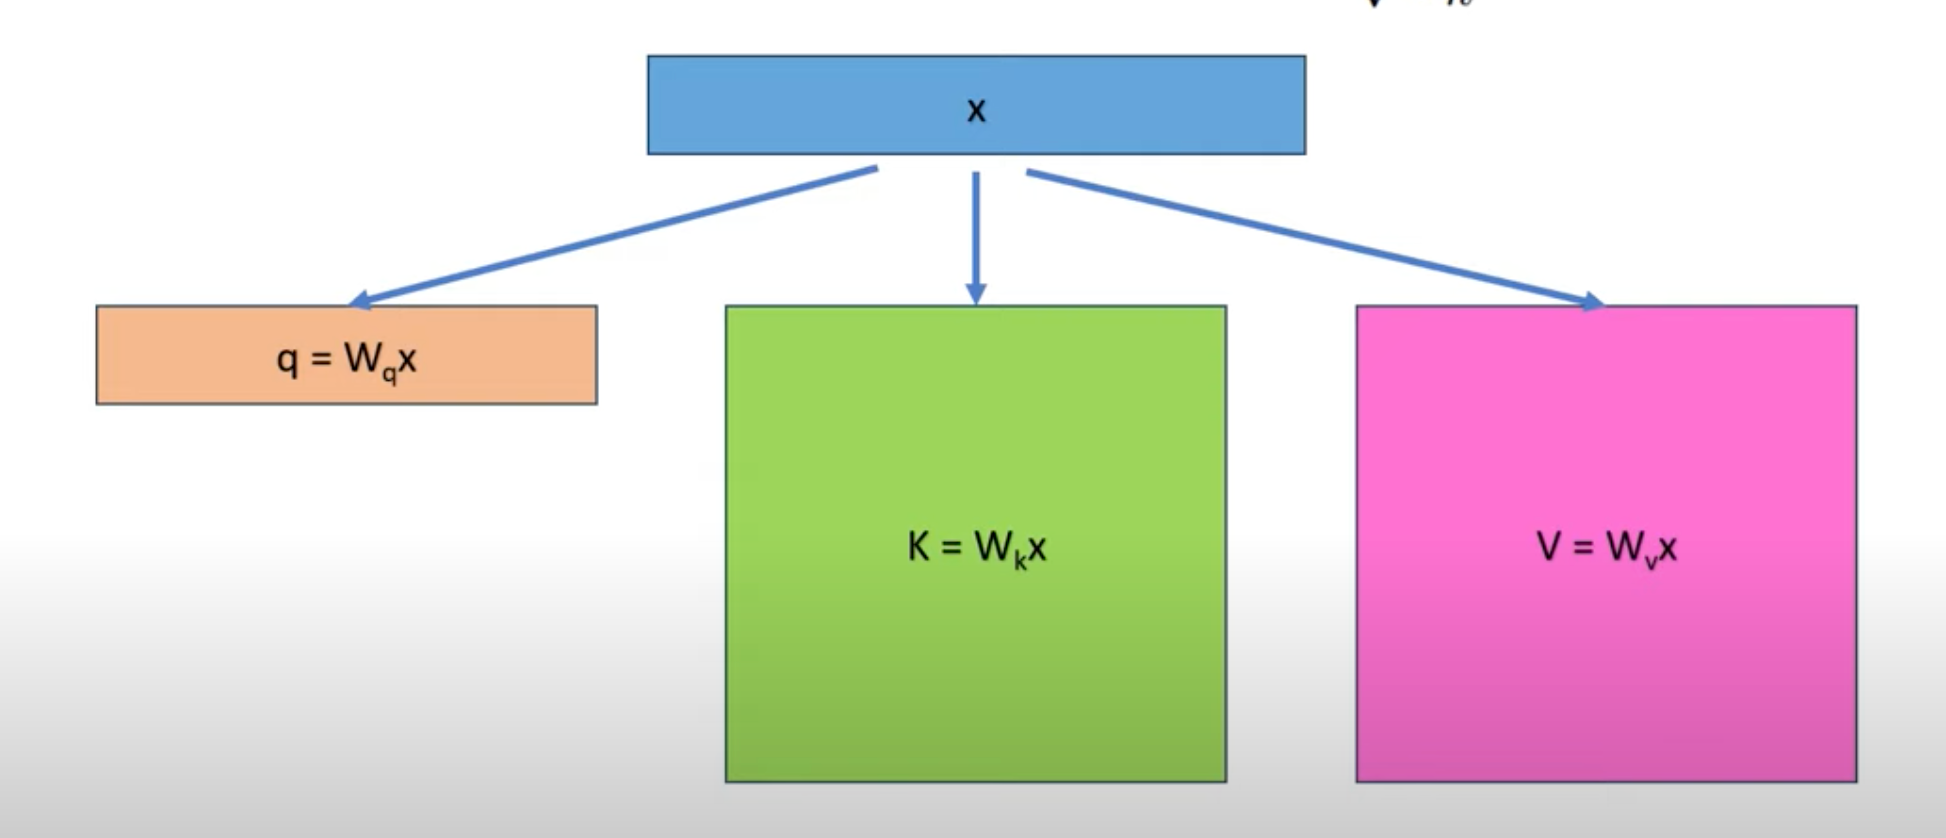

In [7]:
Image('../imgs/decoding-qkv.png', width=600)

### Next Token Prediction task

- NTP training: 
    - Input: [SOS] Love that can quickly seize the gentle heart
    - Target: Love that can quickly seize the gentle heart [EOS]
- NTP inference
    - SOS: start of sentence
    - EOS: end of sentence
|     | Input                                              | Output                                             |
|-----|:---------------------------------------------------|:---------------------------------------------------|
| t=1 | [SOS]                                              | Love                                               |
| t=2 | [SOS] Love                                         | Love that                                          |
| t=3 | [SOS] Love that                                    | Love that can                                      |
| t=4 | [SOS] Love that can                                | Love that can quickly                              |
| t=5 | [SOS] Love that can quickly                        | Love that can quickly seize                        |
| t=6 | [SOS] Love that can quickly seize                  | Love that can quickly seize the                    |
| t=7 | [SOS] Love that can quickly seize the              | Love that can quickly seize the gentle             |
| t=8 | [SOS] Love that can quickly seize the gentle       | Love that can quickly seize the gentle heart       |
| t=9 | [SOS] Love that can quickly seize the gentle heart | Love that can quickly seize the gentle heart [EOS] |

## llama2

| **model** | **heads** | **layers** | **dim** | **head_dim** |
|-----------|-----------|------------|---------|--------------|
| 7b        | 32        | 32         | 4096    | 4096/32      |
| 13b       | 40        | 40         | 5120    | 5120/40      |
| 70b       | 64        | 80         | 8192    | 8192/64      |

In [8]:
from sentencepiece import SentencePieceProcessor
sp_model = SentencePieceProcessor(model_file='./tokenizer.model')

In [9]:
prompt = 'I believe the meaning of life is'
[sp_model.bos_id(), *sp_model.encode(prompt)]

[1, 306, 4658, 278, 6593, 310, 2834, 338]

```
class Attention(nn.Module):
    """Multi-head attention module."""
    def __init__(self, args: ModelArgs):
    
        self.wq = ColumnParallelLinear(args.dim, args.n_heads * self.head_dim)
        self.wk = ColumnParallelLinear(args.dim, self.n_kv_heads * self.head_dim)
        self.wv = ColumnParallelLinear(args.dim, self.n_kv_heads * self.head_dim)
        self.wo = RowParallelLinear(args.n_heads * self.head_dim, args.dim)
        
        
        # [8, 1024, 32, 128]
        self.cache_k = torch.zeros(
            (
                args.max_batch_size,    # 8
                args.max_seq_len,       # 1024
                self.n_local_kv_heads,  # 32
                self.head_dim,          # 128
            )
        ).cuda()
        
        #  [8, 1024, 32, 128]
        self.cache_v = torch.zeros(
            (
                args.max_batch_size,    # 8
                args.max_seq_len,       # 1024
                self.n_local_kv_heads,  # 32
                self.head_dim,          # 128
            )
        ).cuda()
    
    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        
        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)

        self.cache_k = self.cache_k.to(xq)
        self.cache_v = self.cache_v.to(xq)
        
        
        self.cache_k[:bsz, start_pos : start_pos + seqlen] = xk
        self.cache_v[:bsz, start_pos : start_pos + seqlen] = xv
        
        # 这里在复用之前的计算, all_past
        keys = self.cache_k[:bsz, : start_pos + seqlen]
        values = self.cache_v[:bsz, : start_pos + seqlen]
        
```